In [1]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral


In [2]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])

samson_data = split_dataset_paths("../Datasets/samson/", ["mat"])
jasper_data = split_dataset_paths("../Datasets/jasper/", ["mat"])



In [3]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [4]:
data = open_files_array[0]
labels = load_labels_array[0]
print(len(labels.flatten()))

1000000


In [5]:
samson = sc.loadmat(samson_data["mat"][1])["V"]
samson_gt = sc.loadmat(samson_data["mat"][0])
samson_labels = np.argmax(samson_gt['A'].T.reshape((-1,3)), axis=1)

jasper = sc.loadmat(jasper_data["mat"][1])["Y"]
jasper_gt = sc.loadmat(jasper_data["mat"][0])
jasper_labels = np.argmax(jasper_gt['A'], axis=0)


In [19]:
d, l = subFrame(data, labels, 0, 150, 0, 150)

In [20]:
X, y = preprocesing_data(d, l)

In [21]:
print(classesInLabels(y))

[0 1 2 3 4 5]


In [46]:
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
tb = {0 : [[0,1,2,3], [4,5]] , 1 : [[[0],[1,2,3]],[[4],[5]]], 2 : [[[1],[2,3]],[[0],[5]]], 3 : [[[2],[3]],[]]}

sbm = {0: SVC(kernel="rbf", C=1000), 1 : [SVC(kernel="rbf", C=1000), SVC(kernel="rbf", C=1000)], 
                                        2 : [SVC(kernel="rbf", C=1000), SVC(kernel="rbf", C=1000)], 3 : [SVC(kernel="rbf", C=1000), SVC(kernel="rbf", C=1000)] }

pl = SvmDesionTree(X,y,tb, sbm)

KeyError: 3

In [35]:
print(len(pl))


22500


0.6102666666666666


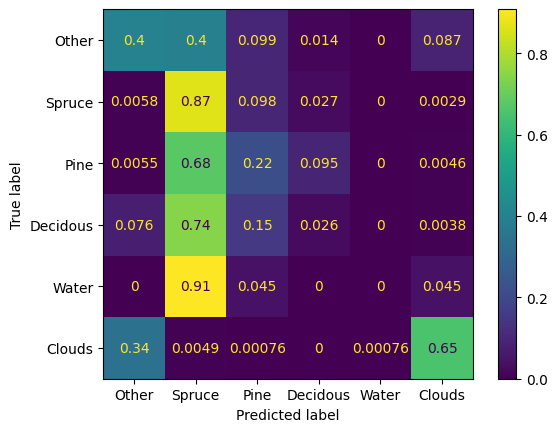

In [43]:
print((pl == y).sum()/len(y))


name_classes = ["Other", "Spruce", "Pine", "Decidous", "Water", "Clouds"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

In [44]:
print(classesInLabels(pl))

[0 1 2 3 4 5]


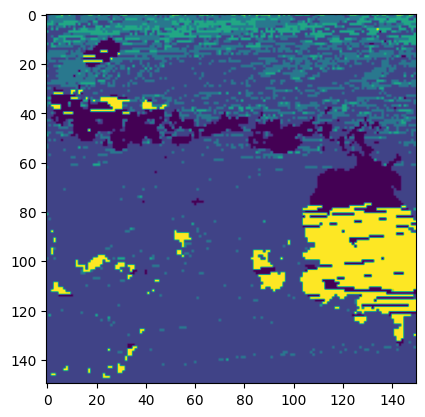

In [45]:
plt.imshow(pl.reshape((150,150)))

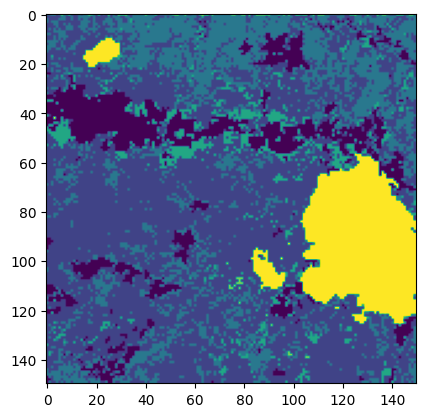

In [41]:
plt.imshow(y.reshape((150,150)))

In [13]:
new_new_samson = reshape_sj(samson)

X = new_new_samson.transpose(0,2,1).reshape((-1,156))
X = preprocessing.scale(X, axis=0)
print(len(X))

y = samson_labels.flatten()

9025


In [70]:
tb = {0: [[1],[0,2]], 1: [[],[[0],[2]]]}

sbm = {0: SVC(kernel="linear", C=1000), 1 : [False,SVC(kernel="linear", C=1000)]}

pl = SvmDesionTree(X,y,tb, sbm)


print((pl == y).sum()/len(y))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Water", "Tree", "Soil"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

0.0


ValueError: Found input variables with inconsistent numbers of samples: [2500, 2]

In [15]:
# split samson into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.999, random_state=1)

In [296]:
new_jasper = reshape_sj(jasper)

X = new_jasper.transpose(0,2,1).reshape((-1,198))
X = preprocessing.scale(X, axis=0)
print(len(X))

y = jasper_labels.flatten()


10000


In [297]:
tb = {0: [[0,2],[1,3]], 1: [[[0],[2]], [[1],[3]]]}

sbm = {0: SVC(kernel="rbf", C=100000), 1 : [SVC(kernel="rbf", C=100000),SVC(kernel="rbf", C=100000)]}

pl = SvmDesionTree(X,y,tb, sbm)



[0 2]
[1 3]
yout len:10000
Fisken print: hallla 
5921
4079


C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\1908230287.py:190: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\1908230287.py:199: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


In [298]:
classesInLabels(pl)

array([0, 1, 2, 3], dtype=int64)

In [299]:
print(len(y))

10000


1.0


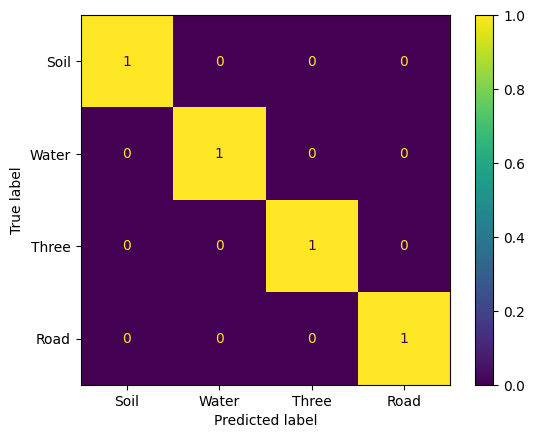

In [300]:

print((pl == y).sum()/len(y))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Soil", "Water", "Three", "Road"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

Fisken print
[0 2 3]
6674
1.0


C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\1658235883.py:189: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):


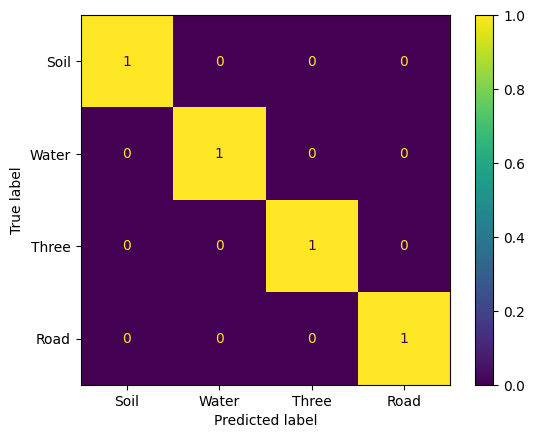

In [259]:
tb = {0: [[0,2,3],[1]], 1: [[[3],[0,2]], []], 2 : [[[0],[2]], []]}

sbm = {0: SVC(kernel="rbf", C=100000), 1 : [SVC(kernel="rbf", C=100000),False], 2: [SVC(kernel="rbf", C=10000), False]}

pl = SvmDesionTree(X,y,tb, sbm)


print((pl == y).sum()/len(y))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Soil", "Water", "Three", "Road"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

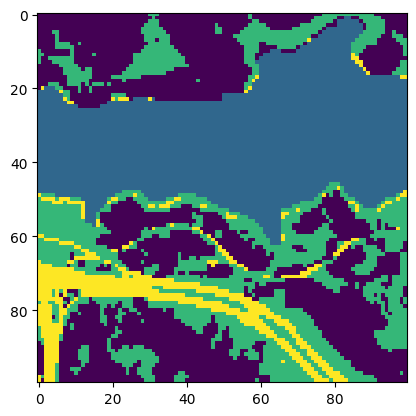

In [260]:

plt.imshow(pl.reshape((100,100)))